In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import tensorflow as tf; tf.compat.v1.disable_eager_execution()
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda, Reshape
from keras.models import Model
from keras.losses import binary_crossentropy
import warnings
warnings.filterwarnings('ignore')
np.random.seed(25)
tf.executing_eagerly()

## Getting the data

In [29]:
from sklearn.datasets import fetch_olivetti_faces
data=fetch_olivetti_faces()
images = data.images.reshape((data.images.shape[0],data.images.shape[1], data.images.shape[2], 1))
labels=(data.target)

X_train, X_test, y_train, y_test = train_test_split(images,labels, test_size=0.01)



In [30]:
X_train.shape

(396, 64, 64, 1)

### Training VAE

In [32]:

img_height   = 64  
img_width    = 64    
num_channels = 1    
input_shape =  (img_height, img_width, num_channels)   
latent_dim = 2

#ENCODER

encoder_input = Input(shape=input_shape)

encoder_conv = Conv2D(filters=8, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder_conv = Conv2D(filters=16, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)

encoder_conv = Conv2D(filters=32, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)

encoder_conv = Conv2D(filters=64, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)


encoder = Flatten()(encoder_conv)

mu = Dense(latent_dim)(encoder)
sigma = Dense(latent_dim)(encoder)

def compute_latent(x):
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim))
    return mu + K.exp(sigma/2)*eps

latent_space = Lambda(compute_latent, output_shape=(latent_dim,))([mu, sigma])
conv_shape = K.int_shape(encoder_conv)

#DECODER
decoder_input = Input(shape=(latent_dim,))
decoder = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
decoder = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(decoder)


decoder_conv = Conv2DTranspose(filters=64, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=32, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=16, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=8, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv =  Conv2DTranspose(filters=num_channels, kernel_size=3, 
                          padding='same', activation='sigmoid')(decoder_conv)


encoder = Model(encoder_input, latent_space)
decoder = Model(decoder_input, decoder_conv)

vae = Model(encoder_input, decoder(encoder(encoder_input)))

def kl_reconstruction_loss(true, pred):
  # Reconstruction loss
  reconstruction_loss = K.sum(K.square(true-pred), axis=[1,2])
  # KL divergence loss
  kl_loss = - 0.5 * K.sum(1 + 2*sigma - K.square(mu) - K.square(K.exp(sigma)), axis=-1)
  return  reconstruction_loss + 1*kl_loss


vae.compile(optimizer='adam', loss=kl_reconstruction_loss)
history = vae.fit(x=X_train, y=X_train, epochs=50, batch_size=32, validation_data=(X_train, X_train))

Train on 396 samples, validate on 396 samples
Epoch 1/50
396/396 [==============================] - 2s 4ms/sample - loss: 133.2164 - val_loss: 119.2340
Epoch 2/50
396/396 [==============================] - 0s 1ms/sample - loss: 107.7511 - val_loss: 96.8156
Epoch 3/50
396/396 [==============================] - 0s 1ms/sample - loss: 94.0099 - val_loss: 90.2610
Epoch 4/50
396/396 [==============================] - 0s 1ms/sample - loss: 88.1643 - val_loss: 86.6874
Epoch 5/50
396/396 [==============================] - 0s 1ms/sample - loss: 83.9756 - val_loss: 80.4606
Epoch 6/50
396/396 [==============================] - 0s 1ms/sample - loss: 79.8295 - val_loss: 75.9198
Epoch 7/50
396/396 [==============================] - 0s 1ms/sample - loss: 75.5231 - val_loss: 72.5432
Epoch 8/50
396/396 [==============================] - 0s 1ms/sample - loss: 71.8845 - val_loss: 71.1008
Epoch 9/50
396/396 [==============================] - 0s 1ms/sample - loss: 69.4887 - val_loss: 67.3630
Epoch 10/50
396

## Generating random data from decoder output

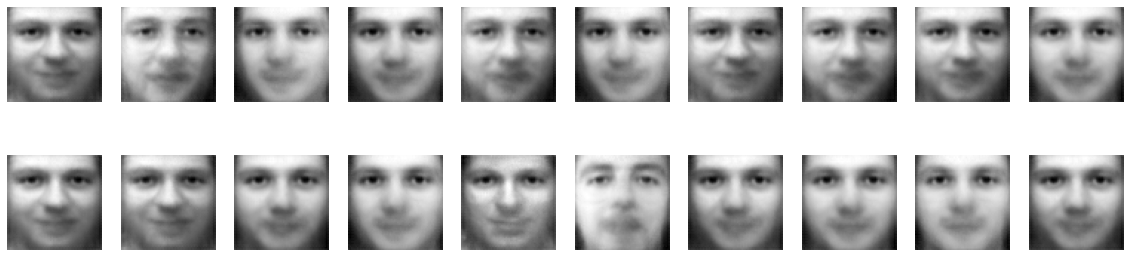

In [40]:
rand_data = np.random.normal(size = 20 * latent_dim).reshape(-1, latent_dim)
new_images = decoder.predict(rand_data)
new_images = new_images.reshape(new_images.shape[0],64, 64)
plt.figure(figsize=(20,5))
for i, dog in enumerate(new_images):
    plt.subplot(2,10,i+1)
    plt.imshow(dog, cmap = 'gray')
    plt.axis('off')

## Latent space grid

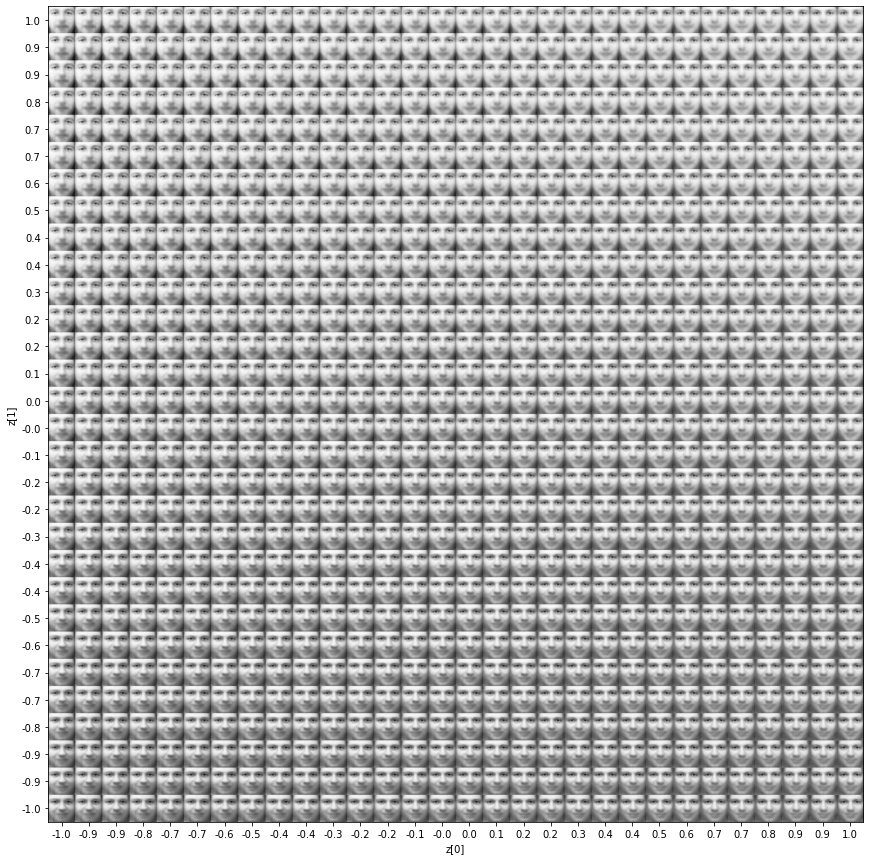

In [41]:
n=30
figsize = 15
digit_size = 64
scale = 1.0
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)[::-1]

for i, yi in enumerate(grid_y):
  for j, xi in enumerate(grid_x):
    z_sample = np.array([[xi, yi]])
    x_decoded = decoder.predict(z_sample)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[
        i * digit_size : (i + 1) * digit_size,
        j * digit_size : (j + 1) * digit_size,] = digit

plt.figure(figsize=(figsize, figsize))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap="Greys_r")
plt.show()